Rayleigh-Taylor instability
======

<table><tr><td><img src='./images/05_raytay_init.png'></td><td><img src='./images/05_raytay.png'></td></tr></table>
(Left) Initial model setup with buoyancy perturbation . (Right) Perturbation growth at time (dimernsionless) 160.

This notebook models the Rayleigh-Taylor instability outlined in van Keken *et al.* (1997). 

The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = -\rho g \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. van Keken, P.E., S.D. King, H. Schmeling, U.R. Christensen, D.Neumeister and M.-P. Doin. A comparison of methods for the modeling of thermochemical convection. Journal of Geophysical Research, 102, 22,477-22,495, 1997.  
http://onlinelibrary.wiley.com/doi/10.1029/97JB01353/abstract


In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis
import math
import numpy as np

Setup parameters
-----

In [2]:
# physical parameters

testing, testing = 0, 0
boxLength      = 0.9142
boxHeight      = 1.0
viscosityRatio = 1.0

# output
inputPath  = 'input/05_Rayleigh_Taylor/'
outputPath = 'output/'

# numerical parameters - demo or 'longtest'
# demo       - settings for a quick run (iff longtest is False)
# 'longtest' - settings for benchmark

longtest = False

model_end_time   = 240.
res              = 32
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5
# users ignore
import os
if "UW_LONGTEST" in os.environ or longtest:
    # to capture the peak V_rms (benchmark) set model_end_time~220
    # the peak V_rms. 
    res              = 128
    stokes_inner_tol = 1e-7
    stokes_outer_tol = 1e-6

In [3]:
# Make output directory if necessary.
if uw.mpi.rank==0:
    import os
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)

Create mesh and finite element variables
------

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

velocityField = mesh.add_variable(         nodeDofCount=2 )
pressureField = mesh.subMesh.add_variable( nodeDofCount=1 )

# initialise 
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Create a particle swarm
------

In [5]:
# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh )

# Create a data variable. It will be used to store the material index of each particle.
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=30 )
swarm.populate_using_layout( layout=swarmLayout )

Initialise each particle's material index
-----

In [6]:
# define these for convience. 
denseIndex = 0
lightIndex = 1

# material perturbation from van Keken et al. 1997
wavelength = 2.0*boxLength
amplitude  = 0.02
offset     = 0.2
k = 2. * math.pi / wavelength

# Create function to return particle's coordinate
coord = fn.coord()

# Define the material perturbation, a function of the x coordinate (accessed by `coord[0]`).
perturbationFn = offset + amplitude*fn.math.cos( k*coord[0] )

# Setup the conditions list. 
# If z is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coord[1] , lightIndex ),
               (                      True , denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
# Results are written to the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Plot the particles by material**


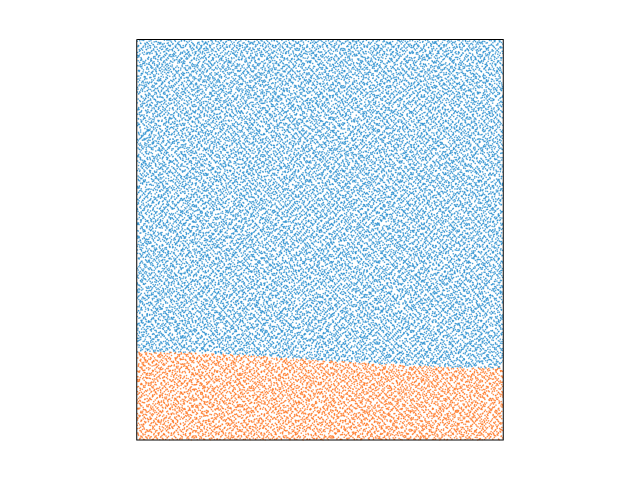

In [7]:
fig1 = vis.Figure()
fig1.append( vis.objects.Points(swarm, materialIndex, pointSize=2, colourBar=False) )
fig1.show()

Map properties to material index
-----
The Map function allows us to create 'per material' type behaviour. Again we use the branching function to set up a (condition, action) command. 

In [8]:
# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = { lightIndex:0., denseIndex:1. }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Set a viscosity value of '1.' for both materials.
viscosityMap = { lightIndex:viscosityRatio, denseIndex:1. }
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = -densityFn*z_hat

Boundary conditions
-----

Create free-slip condition on the vertical boundaries, and a no-slip condition on the horizontal boundaries.

In [9]:
# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["Left_VertexSet"]   + mesh.specialSets["Right_VertexSet"]
jWalls = mesh.specialSets["Bottom_VertexSet"] + mesh.specialSets["Top_VertexSet"]
allWalls = iWalls + jWalls

# Prescribe degrees of freedom on each node to be considered Dirichlet conditions.
# In the x direction on allWalls flag as Dirichlet
# In the y direction on jWalls (horizontal) flag as Dirichlet
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (allWalls, jWalls) )

Create systems
-----

In [10]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = stokesBC,
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.mpi.size==1):
    solver.set_inner_method("lu")
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

Time stepping
-----

In [11]:
# Initialise time and timestep.
time = 0.
step = 0

# parameters for output
outputEvery  = 20
timeVal     = []
vrmsVal     = []

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(outputPath+"Mesh.h5")

In [12]:
# define an update function
def update():
    dt = advector.get_max_dt() # retrieve the maximum possible timestep from the advection system.
    advector.integrate(dt)     # advect step.
    return time+dt, step+1

In [13]:
while time < model_end_time:

    # Get solution
    solver.solve()
    
    # Calculate the RMS velocity.
    vrms = stokes.velocity_rms()

    # Record values into arrays
    if(uw.mpi.rank==0):
        vrmsVal.append(vrms)
        timeVal.append(time)
    
    # Output to disk
    if step%outputEvery == 0:
        if(uw.mpi.rank==0):
            print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

        filename = outputPath+"/velocityField."+str(step)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = outputPath+"/pressureField."+str(step)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = outputPath+"image"+str(step).zfill(4)
        fig1.save_image(outputFilename)

    # We are finished with current timestep, update.
    time, step = update()
    
if(uw.mpi.rank==0):
    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

step =      0; time = 0.000e+00; v_rms = 1.872e-04
step =     20; time = 1.805e+02; v_rms = 1.879e-03
step =     40; time = 2.171e+02; v_rms = 3.007e-03
step =     56; time = 2.409e+02; v_rms = 3.062e-03


Post simulation analysis
-----


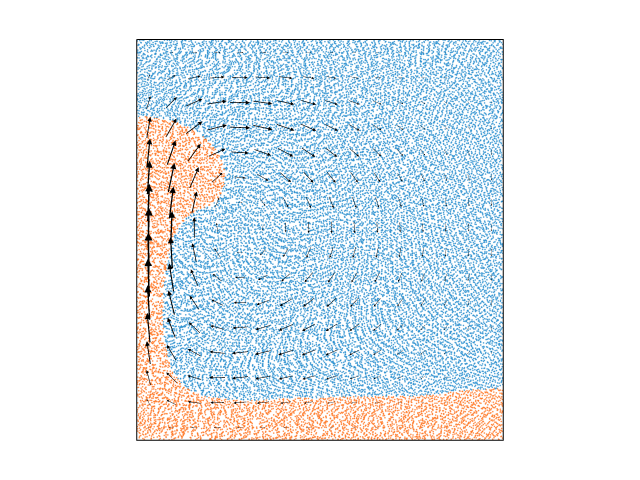

In [14]:
fig1.append( vis.objects.VectorArrows( mesh, velocityField))
fig1.show()

In [15]:
if uw.mpi.rank==0:
    
    maxIndex = np.argmax(vrmsVal)

    print('Viscosity ratio = {0:.2f}'.format(viscosityRatio))
    print('    t(max vrms) = {0:.2f}'.format(timeVal[maxIndex]))
    print('           vrms = {0:.4e}'.format(vrmsVal[maxIndex]))
    
    # output a summary file with benchmark values (useful for parallel runs)
    np.savetxt(outputPath+'summary.txt', [viscosityRatio, timeVal[maxIndex], vrmsVal[maxIndex]])

Viscosity ratio = 1.00
    t(max vrms) = 227.53
           vrms = 3.1447e-03


The benchmark values from van Keken *et al.* 1997 are approximately:

| Viscosity ratio ($\frac{\eta}{\eta_r}$) |  t (max $v_{rms}$) | max $v_{rms}$ |
| :-------------:  | :----------------: | :-----------: |
| 1.00            | 208.99             | 3.0916e-3 |
| 0.10            | 71.92              | 9.458e-3 |
| 0.01            | 49.57              | 1.462e-2 |

**Plot RMS velocity**

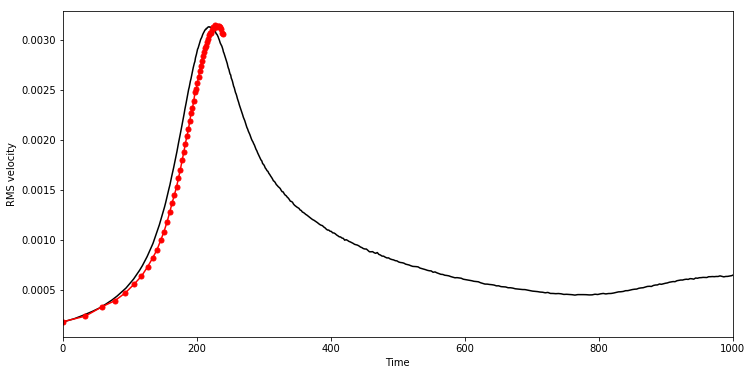

In [16]:
if uw.mpi.size == 1:
    if   viscosityRatio == 1.0 :
        data = np.loadtxt(inputPath+'VrmsCaseA.txt', unpack=True )
    elif viscosityRatio == 0.1 :
        data = np.loadtxt(inputPath+'VrmsCaseB.txt', unpack=True )
    elif viscosityRatio == 0.01 :
        data = np.loadtxt(inputPath+'VrmsCaseC.txt', unpack=True )
    else :
        print('No specific data found - default to Case A')
        data = np.loadtxt(inputPath+'VrmsCaseA.txt', unpack=True )

    # Load into data arrays to compare with timevals and vrmsvals from above.
    timeCompare, vrmsCompare = data[0], data[1] 
    # These can be copied onto timevals and vrmsvals to skip running the time loop.    
    uw.utils.matplotlib_inline()

    import matplotlib.pyplot as pyplot
    fig = pyplot.figure()
    fig.set_size_inches(12, 6)
    ax = fig.add_subplot(1,1,1)
    ax.plot(timeCompare, vrmsCompare, color = 'black') 
    ax.plot(timeVal, vrmsVal, color = 'red', marker=".", markersize=10) 
    ax.set_xlabel('Time')
    ax.set_ylabel('RMS velocity')
    ax.set_xlim([0.0,1000.0])

In [17]:
t_max = 212.          # expected vrms max time
vrms_max = 3.1183e-03 # expected vrms max
if uw.mpi.rank==0:
    if longtest: 
        rtol = 1.e-2
    else:
        rtol = 1.e-1
    if not np.allclose(timeVal[maxIndex], t_max, rtol=rtol):
        raise RuntimeError("Expected t_max ({0:.2f}) is different to encountered value ({1:.2f})".format(t_max,timeVal[maxIndex]))
    if longtest: 
        rtol = 1.e-3
    else:
        rtol = 1.e-2
    if not np.allclose(vrmsVal[maxIndex], vrms_max, rtol=rtol):
        raise RuntimeError("Expected vrms_max ({0:.4e}) is different to encountered value ({1:.4e})".format(vrms_max,vrmsVal[maxIndex]))